## Bayesian Regression Review

Recall that our regression coefficients $\vec{w}$ come from a prior distribution 

\begin{align}
    \vec{w} \sim \mathcal{N}\left(\vec{m}_0, S_0\right)
\end{align}

and the likelihood is 

\begin{align}
    p(\vec{t}|\vec{w}) = \mathcal{N}\left(\vec{t} | \mathbf{\Phi} \vec{w}, \beta^{-1}I\right)
\end{align}

We can then derive the posterior to be 

\begin{align}
    p(\vec{w} | \vec{t}) &= \mathcal{N}\left( \vec{w} \Big| \vec{m}_N, \mathbf{S}_N \right) \\
    \vec{m}_N &= \mathbf{S}_N\left(S_0^{-1} \vec{m_0} + \beta \mathbf{\Phi}^T \vec{t} \right) \\
    \mathbf{S}_N^{-1} &= \mathbf{S}_0^{-1} + \beta \mathbf{\Phi}^T\mathbf{\Phi}
\end{align}

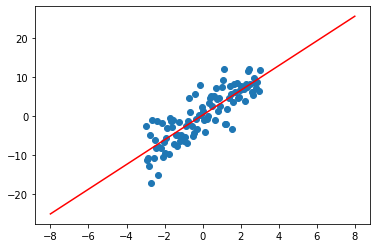

In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1)

# generate toy data
dim = 1
numpoints = 100
x = np.linspace(-3, 3, numpoints)
x = x[np.newaxis].T

slope = 3
eps_mu = 0
beta = 0.25
eps = np.random.normal(eps_mu, 1/beta, size = (numpoints, dim))
t = slope * x + eps

# phi is a column of ones next to the column of x's
phi = np.hstack((np.ones((numpoints, 1)), x))

# choose an uninformative prior for simplicity
m_0 = np.array([[0], [0]])
S_0 = np.eye(2)
beta = 0.25

S_0inv = np.linalg.lstsq(S_0, np.eye(2), rcond = None)[0]
S_n = np.linalg.lstsq(S_0inv + beta * phi.T @ phi, np.eye(2), rcond = None)[0]
m_n = S_n @ (S_0inv @ m_0 + beta * phi.T @ t)

line_x_b = np.linspace(np.min(x)-5, np.max(x) + 5, 100)
line_y_b = m_n[0] + m_n[1]*line_x_b

plt.scatter(x, t)
plt.plot(line_x_b, line_y_b, 'r')
plt.show()

## Online Bayesian Regression

Large datasets often face computational and memory limitations, both of which motivate an **online** or **sequential** update scheme. Similar to stochastic gradient descent for frequentist regression, the online version of Bayesian regression not only allows model parameters to be updated without keeping the entire dataset in memory/storage, but also increases computational efficiency of the training/fitting process. The update rules can be derived as follows.  

Suppose we have $N + M$ observations. Let $\mathbf{\Phi}_{N + M}$ denote the design matrix with $N + M$ feature vectors and $\vec{t}_{N + M}$ be the vector of $N + M$ target values. Then it is clear that we can partition them  

\begin{align}
    \mathbf{\Phi}_{N + M} = \begin{pmatrix}
                                \mathbf{\Phi}_N \\
                                \mathbf{\Phi}_M
                            \end{pmatrix} \quad \vec{t}_{N + M} = \begin{pmatrix}
                                                                        \vec{t}_N \\
                                                                        \vec{t}_M
                                                                    \end{pmatrix}
\end{align}

Thus the updates for $S_{N + M}$ and $m_{N + M}$ can be written as 

\begin{align}
    \mathbf{S}_{N + M}^{-1} &= \mathbf{S}_0^{-1} + \beta \mathbf{\Phi}_{N + M}^T \mathbf{\Phi}_{N + M} \\
    &= \mathbf{S}_0^{-1} + \beta \left(\mathbf{\Phi}_{N}^T\mathbf{\Phi}_{N} + \mathbf{\Phi}_{M}^T\mathbf{\Phi}_{M} \right) \\
    &= \mathbf{S}_N^{-1} + \beta\mathbf{\Phi}_{M}^T\mathbf{\Phi}_{M}\\
    \vec{m}_{N + M} &= \mathbf{S}_{N + M} \left(\mathbf{S}_0^{-1} \vec{m}_0 + \beta \mathbf{\Phi}_{N + M}^T \vec{t}_{N+M}\right) \\
    &= \mathbf{S}_{N + M} \left(\mathbf{S}_0^{-1} \vec{m}_0\right) + \beta \mathbf{S}_{N + M} \left(\mathbf{\Phi}_{N}^T\vec{t}_{N} + \mathbf{\Phi}_{M}^T\vec{t}_{M}\right) \\
    &= \mathbf{S}_{N + M} \left(\mathbf{S}_0^{-1} \vec{m}_0\right) + \mathbf{S}_{N + M} \left(\mathbf{S}_N^{-1} \vec{m}_N - \mathbf{S}_0^{-1}\vec{m}_0\right) + \beta \mathbf{S}_{N + M} \left(\mathbf{\Phi}_M^T \vec{t}_M\right) \\
    &= \mathbf{S}_{N + M} \left(\mathbf{S}_N^{-1} \vec{m}_N\right) + \beta \mathbf{S}_{N + M} \left(\mathbf{\Phi}_M^T \vec{t}_M\right) 
\end{align}

These updates do not require past data to be saved, nor do they require the repeated inclusion of the past $N$ observations when recomputing model parameters (which can be rather costly when data is high dimensional, $N$ is large, or both). 

In [2]:
# we will loop through phi to mimic an incoming stream of data
# same priors as before
m_n = np.array([[0.0], [1.0]])
S_n = np.eye(2)
S_ninv = np.linalg.lstsq(S_n, np.eye(2), rcond = None)[0]
beta = 0.25

for i in range(len(phi[:, 0])):
    S_ninv_old = S_ninv
    
    S_ninv = S_ninv + beta * phi[np.newaxis, i, :].T @ phi[np.newaxis, i, :]
    S_n = np.linalg.lstsq(S_ninv, np.eye(2), rcond = None)[0]
    m_n = S_n @ (S_ninv_old @ m_n + beta * phi[np.newaxis, i, :].T * t[i])

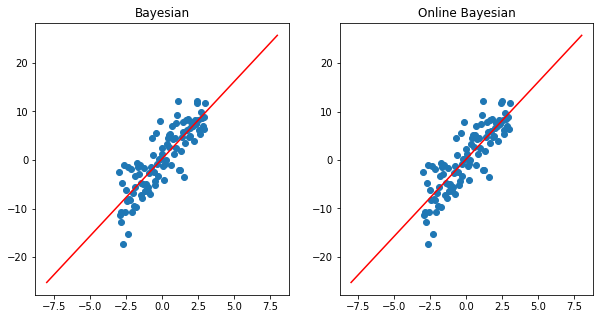

In [3]:
line_x_on = np.linspace(np.min(x)-5, np.max(x) + 5, 100)
line_y_on = m_n[0] + m_n[1]*line_x_on

fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].title.set_text("Bayesian")
ax[0].scatter(x, t)
ax[0].plot(line_x_b, line_y_b, 'r')
ax[1].title.set_text("Online Bayesian")
ax[1].scatter(x, t)
ax[1].plot(line_x_on, line_y_on, 'r')
plt.show()